### Example using real spatial inputs (but simple synthetic geological model)
#### Showcasing LoopStructural-Flopy to address Model Structure Uncertainty

This notebook demonstrates an example of the entire workflow using shape files which are more realistic inputs for meshing. The geological model however is synthetic and overly simplified (note that the fault is not currently working). Head results are non-sensical as made-up geology and forcings.

1. Setup project 
2. Spatial data
3. Meshing
4. Geological model
5. Flow model discretisation (DIS inputs)
6. Flow model hydraulic properties (NPF inputs)
7. Flow model packages (IC, CHD, WEL, RCH, OBS inputs)


In [1]:
import pandas as pd
import numpy as np
import subprocess
import sys
import os
import pickle
from shapely.geometry import LineString,Point,Polygon,shape
import pathlib

%load_ext autoreload
%autoreload 2

import functions
sys.path.append('../../MODFLOW_Tools')    
logfunc = lambda e: np.log10(e)

### 1. Setup project 

#### Model boundary

In [2]:
#### ACTIVE MODEL AREA
import geopandas as gpd
model_boundary = gpd.read_file('../data/shp/model_boundary.shp')
model_boundary.to_crs(epsg=28350, inplace=True)
inner_boundary = model_boundary.buffer(-300)

from meshing_routines import resample_poly
model_boundary = resample_poly(model_boundary, 1500) 
inner_boundary = resample_poly(inner_boundary, 1500) 

x0, y0, x1, y1 = model_boundary.bounds

Meshing routines loaded!


In [3]:
from loop2flopy import Project
P = Project('testproject', boundingbox = [x0, x1, y0, y1, -1200, 100]) # (x0, x1, y0, y1, z0, z1)
P.crs = "epsg:28350" # Put in coordinate reference

P.workspace = '../modelfiles/example'
P.results = '../results/example'
P.triExeName = '../exe/triangle.exe'

if not os.path.isdir(P.workspace): os.makedirs(P.workspace, exist_ok=True)
if not os.path.isdir(P.results): os.makedirs(P.results, exist_ok=True)

loop2flopy routines loaded!


### 2. Spatial data

#### Observation bores

In [4]:
#### OBS BORES
bore_df = pd.read_excel('../data/example_data.xls', sheet_name = 'bore_info')
bore_gdf = gpd.GeoDataFrame(bore_df, geometry=gpd.points_from_xy(bore_df.Easting, bore_df.Northing), crs="epsg:28350")
obs_bores = gpd.clip(bore_gdf, model_boundary)
P.idobsbores = list(obs_bores.ID)
P.xyobsbores = list(zip(obs_bores.Easting, obs_bores.Northing))
type(obs_bores)

geopandas.geodataframe.GeoDataFrame

#### Pumping bores

In [5]:
### PUMPING BORES
P.xypumpbores = [(370000, 6515000), (365700, 6525000)] # # Fake pumping bores
P.idpumpbores = ['P1', 'P2']
P.xpumpbores, P.ypumpbores = list(zip(*P.xypumpbores))
pump_bores = gpd.GeoDataFrame(pd.DataFrame({'id': P.idpumpbores, 'x': P.xpumpbores, 'y': P.ypumpbores}), 
                       geometry=gpd.points_from_xy(x=P.xpumpbores, y=P.ypumpbores))
type(pump_bores)

geopandas.geodataframe.GeoDataFrame

#### Head boundary

In [6]:
#### HEAD BOUNDARIES
east_chd = gpd.read_file('../data/shp/east_chd.shp')
east_chd.to_crs(epsg=28350, inplace=True)
east_chd = gpd.clip(east_chd, model_boundary)
type(east_chd)

geopandas.geodataframe.GeoDataFrame

#### Fault

In [7]:
#### FAULT
P.fault_buffer = 800

# Create a shape file of Badaminna Fault
fx = [374540,374540,374000,374700,374750,373500,374000,374000]
fy = [6490000,6502303,6515000,6520000,6525000,6530000,6545000,6550000]
fault_trace = LineString(list(zip(fx, fy)))
fault_gdf = gpd.GeoDataFrame(geometry=[fault_trace], crs = P.crs)
fault_gdf.to_file('../data/shp/badaminna_trace.shp')

# Import fault shape file
bada_shp = gpd.read_file('../data/shp/badaminna_trace.shp')
bada_shp.to_crs(epsg=28350, inplace=True)
bada_shp = gpd.clip(bada_shp, model_boundary)

from meshing_routines import prepare_fault_nodes_voronoi
fault_refinement_nodes = prepare_fault_nodes_voronoi(P, '../data/shp/badaminna_trace.shp', model_boundary, inner_boundary)
type(bada_shp)

geopandas.geodataframe.GeoDataFrame

#### Plot of spatial inputs

Text(0.5, 1.0, 'Badaminna Model')

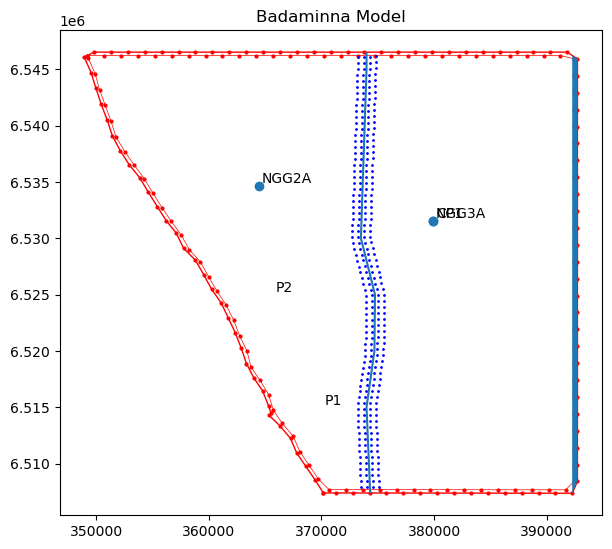

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize = (7,7))
x, y = model_boundary.exterior.xy
ax.plot(x, y, '-o', ms = 2, lw = 1, color='red')
x, y = inner_boundary.exterior.xy
ax.plot(x, y, '-o', ms = 2, lw = 0.5, color='red')

obs_bores.plot(ax=ax, zorder=2)
#pump_bores.plot(ax=ax, zorder=2)
east_chd.plot(ax=ax, zorder=2)
bada_shp.plot(ax=ax, zorder=2)

for coord in fault_refinement_nodes:
    ax.plot(coord[0], coord[1], 'bo', ms = 1, zorder = 3) 

for x, y, label in zip(obs_bores.geometry.x, obs_bores.geometry.y, obs_bores.ID):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
for x, y, label in zip(pump_bores.geometry.x, pump_bores.geometry.y, pump_bores.id):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
ax.set_title('Badaminna Model')

### 3. Meshing 

#### Refinement criteria

In [9]:
P.nobs = len(P.xyobsbores)
#P.npump = len(P.xypumpbores)

P.model_maxtri = 999999
P.angle = 32   # minimum triangle angles
P.radius1 = 500 # radius of inner circle around pumping bores
P.radius2 = 1000 # radius of outer circle around pumping bores
P.boremaxtri = 999999

#### Prepare polygons and nodes for meshing

In [10]:
# This function prepares refinement polygons around bores (bore coords are used as nodes)
def prepboremesh(P):
    
    theta = np.linspace(0, 2 * np.pi, 11)
    pump_bores_inner, pump_bores_outer = [], []
    obs_bores_inner, obs_bores_outer = [], []

    for i in P.xypumpbores:   
        X = i[0] + P.radius1 * np.cos(theta)
        Y = i[1] + P.radius1 * np.sin(theta)    
        vertices_inner = [(x_val, y_val) for x_val, y_val in zip(X, Y)]
        X = i[0] + P.radius2 * np.cos(theta)
        Y = i[1] + P.radius2 * np.sin(theta)    
        vertices_outer = [(x_val, y_val) for x_val, y_val in zip(X, Y)]
        pump_bores_inner.append(vertices_inner)
        pump_bores_outer.append(vertices_outer)

    return(pump_bores_inner, pump_bores_outer)

############ NODES = pump and obs bores, fault nodes (prepfaultmesh)
# For Voronoi Mesh, nodes include: pumping and observation bores, fault points

nodes = []

# BORES
for point in P.xypumpbores:
    nodes.append(point)
for point in P.xyobsbores:
    nodes.append(point)
    
# FAULT REFINEMENT POINTS
for point in fault_refinement_nodes: # Four lines of points
    nodes.append(point)
nodes = np.array(nodes)

############ POLYGONS
# For Voronoi Mesh, polygons include: model boundary, refinement polygons around pumping bores

polygons = [] # POLYGONS[(polygon, (x,y), maxtri)]

# MODEL BOUNDARY - Use shapely object for boundary
polygons.append((list(model_boundary.exterior.coords), 
                 (model_boundary.representative_point().x, model_boundary.representative_point().y), 
                  P.model_maxtri)) # Inside boundary frame

# PUMPING BORES - Use polygons generated from prepboremesh

boresinner, boresouter = prepboremesh(P)
for i in range(len(P.xypumpbores)): # Append pumping bore zone polygons
    polygons.append((boresinner[i], P.xypumpbores[i], P.boremaxtri))
    polygons.append((boresouter[i],0, 0)) # 0, 0 means don't refine inside polygon

In [11]:
nodes.shape


(297, 2)

#### Create mesh arrays (cell2d, xcyc, vertices)

In [12]:
from meshing_routines import vor_meshing
P.cell2dvor, P.xcycvor, P.verticesvor, P.vor = vor_meshing(P, polygons, nodes)

#### Plot grid

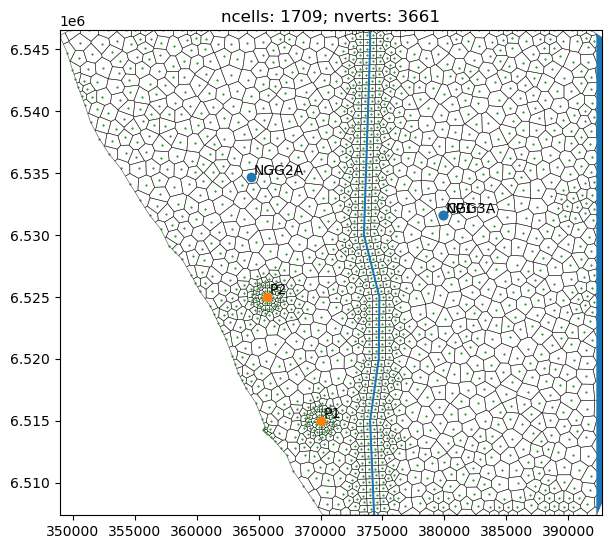

In [13]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(1, 1, 1, aspect='equal')
P.vor.plot(edgecolor='black', lw = 0.4, alpha = 0.7)
for i in P.xcycvor: ax.plot(i[0], i[1], 'o', color = 'green', ms = 0.5)
obs_bores.plot(ax=ax, zorder=2)
pump_bores.plot(ax=ax, zorder=2)
east_chd.plot(ax=ax, zorder=2)
bada_shp.plot(ax=ax, zorder=2)
for x, y, label in zip(obs_bores.geometry.x, obs_bores.geometry.y, obs_bores.ID):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
for x, y, label in zip(pump_bores.geometry.x, pump_bores.geometry.y, pump_bores.id):
    ax.annotate(label, xy=(x, y), xytext=(2, 2), textcoords="offset points")
#ax.set_xlim([368000,374000]) #([365000,380000])
#ax.set_ylim([P.y0, 6510000]) #([P.y0, 6520000])

### 4. Geological Model

In [14]:
def prepare_geomodel(P, data, strat, include_fault):
    import numbers
    df = data.copy()
    units = list(df.columns.values[5:])   # Make a list of formations  
    #df.Easting = pd.to_numeric(df.Easting)    # Make sure Eastings and Northings are numeric values
    #df.Northing = pd.to_numeric(df.Northing)
    #df.Ground = pd.to_numeric(df.Ground)

    # ---------- Prepare borehole data ----------------
    data_list = df.values.tolist()  # Turn data into a list of lists
    formatted_data = []
    for i in range(len(data_list)): #iterate for each row
        
        data_type = data_list[i][3]  
        
        #-----------RAW DATA-----------------------
        if data_type == 'Raw': ### Z VALUES: Ground (mAHD), Else: (mBGL)
            
            boreid = data_list[i][0]
            easting, northing = data_list[i][1], data_list[i][2]
            groundlevel = data_list[i][5]  

            # Add ground level to dataframe
            formatted_data.append([boreid, easting, northing, groundlevel, 0, 'Ground', 'Ground', 0, 0, 1, data_type]) 

            count = 1  # Add data row for each lithology
            for j in range(6,df.shape[1]-1): #iterate through each formation 
                if isinstance(data_list[i][j], numbers.Number) == True:  # Add lithology  
                    bottom    = groundlevel - float(data_list[i][j])  # Ground surface - formation bottom (mbgl)
                    val       = strat.val[count]                   # designated isovalue
                    unit      = strat.unit[count]                  # unit 
                    feature   = strat.sequence[count]              # sequence
                    gx, gy, gz = 0,0,1                             # normal vector to surface (flat) 
                    formatted_data.append([boreid, easting, northing, bottom, val, unit, feature, gx, gy, gz, data_type])    
                    current_bottom = np.copy(bottom)    
                count+=1
        
        #-----------CONTROL POINT-----------------------
        if data_type == 'Control': ### Z VALUES: mAHD
            boreid = data_list[i][0]
            easting, northing = data_list[i][1], data_list[i][2]

            count = 1  # Add data row for each lithology
            for j in range(6,df.shape[1]-1): #iterate through each formation 
                if isinstance(data_list[i][j], numbers.Number) == True:  # Add lithology  
                    Z         = float(data_list[i][j])             # elevation (mAHD)
                    val       = strat.val[count]                   # designated isovalue
                    unit      = strat.unit[count]                  # unit 
                    feature   = strat.sequence[count]              # sequence
                    gx, gy, gz = 0,0,1                             # normal vector to surface (flat) 
                    formatted_data.append([boreid, easting, northing, Z, val, unit, feature, gx, gy, gz, data_type])      
                count+=1
                
    data = pd.DataFrame(formatted_data)
    data.columns =['ID','X','Y','Z','val','lithcode','feature_name', 'gx', 'gy', 'gz','data_type']
    
    # ---------- Prepare fault details ----------------   
    if include_fault:
        # To make points along fault surface
        gdf = gpd.read_file('../data/shp/badaminna_trace.shp') 
        fault = gpd.clip(gdf, model_boundary) # fault is a gdf
        df = fault.get_coordinates()
        fault_points = list(zip(list(df.x), list(df.y)))
        fault_linestring = LineString(fault_points)

        # Settings to make point cloud
        #Lfault = fault.length
        #r = fault.length/20 # distance between points
        r = 2*P.fault_buffer/3 # distance between points
        from meshing_routines import resample_linestring
        ls = resample_linestring(fault_linestring, r)

        fx, fy = [], []
        for point in ls:
            x,y = point.x, point.y
            fx.append((x))
            fy.append((y))
        fz = [-500] # making a plane

        from LoopStructural.utils import strikedip2vector # array of arrays
        dip = 90 # Vertical fault
        fault_rows= []

        for v in range(len(fz)):# vertical points 
            z = fz[v]
            for n in range(len(fx)-1): # fault segments = number of fault points - 1

                if fx[n+1] - fx[n] == 0: # fault due N-S
                    strike = 0
                    x = fx[n]
                    if fy[n+1] > fy[n]: # moving north
                        y = fy[n] + (fy[n+1] - fy[n]) / 2
                        nx, ny, nz = strikedip2vector([strike], [dip])[0]
                        fault_rows.append([x, y, z, nx, ny, nz])

                    else: # moving south
                        y = fy[n] - (fy[n+1] - fy[n]) / 2
                        nx, ny, nz = strikedip2vector([strike], [dip])[0]
                        fault_rows.append([x, y, z, nx, ny, nz])
                else:
                    grad = (fy[n+1] - fy[n]) / (fx[n+1] - fx[n]) # gradient of segment
                    x = fx[n] + (fx[n+1] - fx[n])/2 # midpoint along fault segment
                    y = fy[n] + (fy[n+1] - fy[n])/2 # midpoint along fault segment
                    strike = np.rad2deg(np.arctan((fx[n+1] - fx[n]) / abs(fy[n+1] - fy[n])))
                    #strike = 90 - np.rad2deg(np.arctan(abs(fy[n+1] - fy[n]) / (fx[n+1] - fx[n])))
                    nx, ny, nz = strikedip2vector([strike], [dip])[0]
                    fault_rows.append([x, y, z, nx, ny, nz])
        
        for i in fault_rows:
            df_new_row = pd.DataFrame.from_records(
                    {
                        "X": [i[0]],
                        "Y": [i[1]],
                        "Z": [i[2]],
                        "val": [0.0],
                        "feature_name": ["Fault"],
                        "nx": [i[3]],
                        "ny": [i[4]],
                        "nz": [i[5]],
                        "ID" : ["Fault_cloud"],
                        "data_type" : ["Fault"]
                    }
                )
            data = pd.concat([data, df_new_row], ignore_index=True)      
    
    return(data, strat)

In [15]:
# ----------- PREPARE GOEMODEL----------------------------
bore_data = pd.read_excel('../data/example_data.xls', sheet_name = 'bore_info')
strat_df = pd.read_excel('../data/example_data.xls', sheet_name = 'strat')
P.data, P.strat = prepare_geomodel(P, bore_data, strat_df, include_fault = True)  # Prepare geomodel inputs
#.data[P.data.lithcode == 'Ground']
P.data

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz,data_type,nx,ny,nz
0,NGG2A,364415.700000,6.534636e+06,27.0,0.0,Ground,Ground,0.0,0.0,1.0,Raw,NaN,NaN,NaN
1,NGG2A,364415.700000,6.534636e+06,-8.0,5.0,TQ,TQ,0.0,0.0,1.0,Raw,NaN,NaN,NaN
2,NGG2A,364415.700000,6.534636e+06,-183.0,-174.0,Kcok,Kcok,0.0,0.0,1.0,Raw,NaN,NaN,NaN
3,NGG2A,364415.700000,6.534636e+06,-313.0,-184.0,Kwlp,Leed,0.0,0.0,1.0,Raw,NaN,NaN,NaN
4,NGG3A,379899.500000,6.531566e+06,46.0,0.0,Ground,Ground,0.0,0.0,1.0,Raw,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,Fault_cloud,373956.771440,6.543703e+06,-500.0,0.0,NaN,Fault,NaN,NaN,NaN,Fault,0.999445,-0.033315,6.123234e-17
77,Fault_cloud,373974.539350,6.544236e+06,-500.0,0.0,NaN,Fault,NaN,NaN,NaN,Fault,0.999445,-0.033315,6.123234e-17
78,Fault_cloud,373991.711652,6.544769e+06,-500.0,0.0,NaN,Fault,NaN,NaN,NaN,Fault,0.999517,-0.031082,6.123234e-17
79,Fault_cloud,374000.000000,6.545302e+06,-500.0,0.0,NaN,Fault,NaN,NaN,NaN,Fault,1.000000,-0.000000,6.123234e-17


In [16]:
P.data[P.data.lithcode == 'TQ']

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz,data_type,nx,ny,nz
1,NGG2A,364415.7,6534636.0,-8.0,5.0,TQ,TQ,0.0,0.0,1.0,Raw,NaN,NaN,NaN
5,NGG3A,379899.5,6531566.0,11.0,5.0,TQ,TQ,0.0,0.0,1.0,Raw,NaN,NaN,NaN


In [17]:
P.data[P.data.lithcode == 'Kcok']

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz,data_type,nx,ny,nz
2,NGG2A,364415.7,6534636.0,-183.0,-174.0,Kcok,Kcok,0.0,0.0,1.0,Raw,NaN,NaN,NaN
7,CP1,379899.5,6531566.0,100.0,-174.0,Kcok,Kcok,0.0,0.0,1.0,Control,NaN,NaN,NaN


In [18]:
P.data[P.data.lithcode == 'Kwlp']

,ID,X,Y,Z,val,lithcode,feature_name,gx,gy,gz,data_type,nx,ny,nz
3,NGG2A,364415.7,6534636.0,-313.0,-184.0,Kwlp,Leed,0.0,0.0,1.0,Raw,NaN,NaN,NaN
6,NGG3A,379899.5,6531566.0,-254.0,-184.0,Kwlp,Leed,0.0,0.0,1.0,Raw,NaN,NaN,NaN


In [19]:
P.strat

,sequence,unit,lithid,val,R,G,B
0,Ground,Ground,-1,60,255,255,255
1,TQ,TQ,0,5,255,255,0
2,Kcok,Kcok,1,-174,255,204,153
3,Leed,Kwlp,2,-184,204,255,51
4,Leed,Kwlw,3,-569,153,204,0
5,Leed,Kwlm,4,-739,102,153,0


In [20]:
lithcodes = P.strat.unit.tolist()
print(lithcodes)

stratcolors = []
for i in range(len(lithcodes)):
    R = P.strat.R.loc[i].item() / 255
    G = P.strat.G.loc[i].item() / 255
    B = P.strat.B.loc[i].item() / 255
    stratcolors.append([round(R, 2), round(G, 2), round(B, 2)])

['Ground', 'TQ', 'Kcok', 'Kwlp', 'Kwlw', 'Kwlm']


In [21]:
def create_geomodel(P, include_fault):
    origin  = (P.x0, P.y0, P.z0)
    maximum = (P.x1, P.y1, P.z1)
    import LoopStructural
    from LoopStructural import GeologicalModel
    print(LoopStructural.__version__)
    geomodel = GeologicalModel(origin, maximum)
    geomodel.set_model_data(P.data)  
    
    Ground         = geomodel.create_and_add_foliation("Ground", nelements=1e4)
    Ground_UC      = geomodel.add_unconformity(Ground, P.strat[P.strat.unit == 'Ground'].val.iloc[0]) 
    TQ         = geomodel.create_and_add_foliation("TQ", nelements=1e4)
    TQ_UC      = geomodel.add_unconformity(TQ, P.strat[P.strat.unit == 'TQ'].val.iloc[0]) 
    
    if include_fault:
        print('Fault included!')
        faultfunction = create_faultfunction()
        Fault = geomodel.create_and_add_fault('Fault', 
                                              displacement      = 200,
                                              #fault_center      = P.fault_center,
                                              #minor_axis        = P.minor_axis, # fault_influence
                                              #fault_slip_vector = P.fault_slip_vector,
                                              #major_axis        = P.major_axis, # fault_extent
                                              #intermediate_axis = P.intermediate_axis, # fault_vertical_radius
                                              #fault_dip_anisotropy=0.0,
                                              #fault_trace_anisotropy=0.0,
                                              #faultfunction     = faultfunction, #'BaseFault', 
                                              #nelements=4000, 
                                              #steps=4, 
                                              #interpolatortype="FDI", 
                                              #buffer=0.3, 
                                              #solver='cg',
                                              )    
        
    Kcok       = geomodel.create_and_add_foliation("Kcok", nelements=1e4, buffer=0.1)
    Leed       = geomodel.create_and_add_foliation("Leed", nelements=1e4, buffer=0.1)

    print(geomodel.feature_name_index)
    
    # Add Strat Column
    stratigraphic_column = {}
    
    stratigraphic_column["Ground"] = {}
    stratigraphic_column["Ground"]["Ground"] = {"min": P.strat[P.strat.unit == 'Ground'].val.iloc[0], 
                                                "max": np.inf, "id": -1, "color": [1.0, 1.0, 1.0]}
    stratigraphic_column["TQ"] = {}
    stratigraphic_column["TQ"]["TQ"] = {"min": P.strat[P.strat.unit == 'TQ'].val.iloc[0], 
                                        "max": np.inf,
                                        "id": 0, "color": stratcolors[0]}
    
    stratigraphic_column["Kcok"] = {}
    stratigraphic_column["Kcok"]["Kcok"] = {"min": P.strat[P.strat.unit == 'Kcok'].val.iloc[0], 
                                            "max": np.inf,
                                            "id": 1, "color": stratcolors[2]}
    stratigraphic_column["Leed"] = {}
    stratigraphic_column["Leed"]["Kwlp"] = {"min": P.strat[P.strat.unit == 'Kwlp'].val.iloc[0], 
                                            "max": np.inf,
                                            "id": 2, "color": stratcolors[3]}
    stratigraphic_column["Leed"]["Kwlw"] = {"min": P.strat[P.strat.unit == 'Kwlw'].val.iloc[0], 
                                            "max": P.strat[P.strat.unit == 'Kwlp'].val.iloc[0], 
                                            "id": 3, "color": stratcolors[4]}
    stratigraphic_column["Leed"]["Kwlm"] = {"min": -np.inf, 
                                            "max": P.strat[P.strat.unit == 'Kwlw'].val.iloc[0], 
                                            "id": 4, "color": stratcolors[5]}

    geomodel.set_stratigraphic_column(stratigraphic_column)
       
    return(geomodel)

In [22]:
# -------------- CREATE GEOMODEL-------------------
geomodel = create_geomodel(P, include_fault = False) # Make geomodel

1.6.1
{'Ground': 0, 'Ground_unconformity': 1, 'TQ': 2, 'TQ_unconformity': 3, 'Kcok': 4, 'Leed': 5}


C:\Users\19904604\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\LoopStructural\modelling\core\geological_model.py:646: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


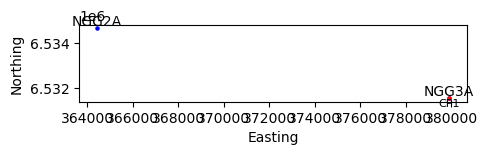

In [23]:
def plot_bores(df):
    df = df.reset_index(drop=True)
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111,aspect='equal')
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    i = 0
    for (xi, yi) in zip(df.X, df.Y):
        if df.lithcode[i] == 'Ground' and df.data_type[i] == 'Raw':
            ax.scatter(df.X[i], df.Y[i], color = 'blue', s = 5)
            ax.text(xi, yi, df.ID[i], size = 10, va='bottom', ha='center')
        if df.data_type[i] == 'Control':
            ax.scatter(df.X[i], df.Y[i], color = 'red', s = 5)
            ax.text(xi, yi, df.ID[i], size = 8, va='top', ha='center')
        i += 1
    #ax.set_xlim(350000,380000)
    #ax.set_ylim(6515000, 6530000)
    
plot_bores(P.data)

In [24]:
P.geomodel = geomodel
#dir(P.geomodel)
strat_ids = P.geomodel.stratigraphic_ids()
features = P.geomodel.feature_names()
#geomodel.stratigraphic_column
print(strat_ids)
print(features)

[[-1, 'Ground', 'Ground', np.int64(60), inf], [0, 'TQ', 'TQ', np.int64(5), inf], [1, 'Kcok', 'Kcok', np.int64(-174), inf], [2, 'Leed', 'Kwlp', np.int64(-184), inf], [3, 'Leed', 'Kwlw', np.int64(-569), np.int64(-184)], [4, 'Leed', 'Kwlm', -inf, np.int64(-569)]]
dict_keys(['Ground', 'Ground_unconformity', 'TQ', 'TQ_unconformity', 'Kcok', 'Leed'])


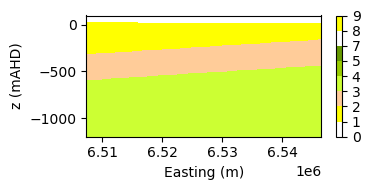

In [25]:
# TRANSECT NORTH-SOUTH
ry, rz = 200, 200
y, z = np.linspace(P.y0, P.y1, ry), np.linspace(P.z0, P.z1, rz)
yy, zz = np.meshgrid(y, z)
x_transects = [386000]        

for j in range(len(x_transects)):
    xx = np.zeros_like(yy)
    xx[:] = x_transects[j]
    geo = geomodel.evaluate_model(np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T).reshape(np.shape(yy)) 
    
    plt.figure(figsize=(4, 2))
    plt.subplot(111)
    plt.contourf(yy,zz,geo,[0, 1, 2, 3, 4, 5, 7, 8, 9],colors=stratcolors,)

    cbar = plt.colorbar()
    #cbar.ax.set_yticklabels(['a','b','c','d',' ']) #P.strat.unit.tolist(), verticalalignment = 'center')
    plt.ylim([-1200,100])
    plt.ylabel('z (mAHD)')
    plt.xlabel('Easting (m)')
    plt.tight_layout()

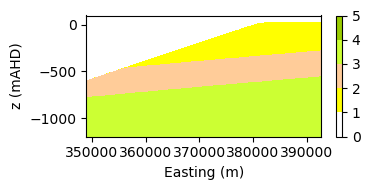

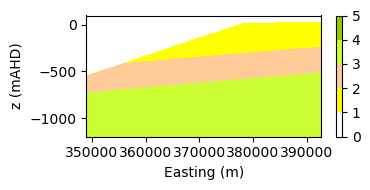

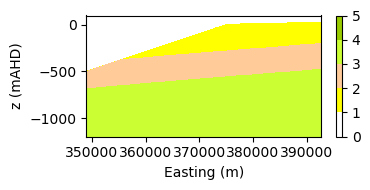

In [26]:
# TRANSECT WEST-EAST
rx, rz = 400, 400
x, z = np.linspace(P.x0, P.x1, rx), np.linspace(P.z0, P.z1, rz)
xx, zz = np.meshgrid(x, z)
y_transects = [6510000, 6520000, 6530000]        

for j in range(len(y_transects)):
    yy = np.zeros_like(xx)
    yy[:] = y_transects[j]
    geo = geomodel.evaluate_model(np.array([xx.flatten(), yy.flatten(), zz.flatten()]).T).reshape(np.shape(xx))  
    plt.figure(figsize=(4, 2))
    plt.subplot(111)
    plt.contourf(xx,zz,geo,[0, 1, 2, 3, 4, 5],colors=stratcolors,)

    cbar = plt.colorbar()
    #cbar.ax.set_yticklabels(['a','b','c','d',' ']) #P.strat.unit.tolist(), verticalalignment = 'center')
    plt.ylabel('z (mAHD)')
    plt.xlabel('Easting (m)')
    plt.tight_layout()

In [27]:
# Still working on this for the workflow

#print(geomodel.bounding_box.nsteps)
#geomodel.bounding_box.nelements = 1e6
#print(geomodel.bounding_box.nsteps)
#surfaces = geomodel["Ground"].surfaces([P.strat[P.strat.unit == 'Ground'].val.iloc[0]])
#
#import pyvista as pv
#from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
#p = pv.Plotter()
#
##p.add_mesh(surfaces[0].vtk)
##p.show()
#
#from LoopStructural.interpolators.supports import P1Unstructured2d, StructuredGrid2D
#mesh = P1Unstructured2d(surfaces[0].triangles, surfaces[0].vertices[:, 0:2], surfaces[0].triangles[:, 0:3])
#
#structured2d = StructuredGrid2D(origin=np.zeros(2), step_vector=np.ones(2), nsteps=np.ones(2, dtype=int) * 11)
#pts = structured2d.barycentre
#
#z = mesh.evaluate_value(pts, surfaces[0].vertices[:, 2])
#
## we expect the values to be close to zero depending on the resultion of the interpolation
#geomodel["Ground"].evaluate_value(np.hstack([pts, z[:, np.newaxis]]))

### 5. Flow model discretisation (DIS inputs)

In [28]:
# ------------- FLOW MODEL PARAMETERS -----------------------#
P.nlv = 100  # number of layers for voxel transect grid
P.nlg = len(lithcodes) -1   # number of geological layers (-1 is due to ground)
P.nls = 2    # number of sublayers (per geological layer)
P.geo_pl = 4 # Which geological layer pumping from (zero-based)
P.res = 2    # vertical resolution upon which voxel grid created to pick lithology bottoms

from loop2flopy import Model
M = Model('Example', P, plan = 'vor', transect = 'con') 
M.create_lith_dis_arrays(P)

   Creating lithology and discretisation arrays for  Example  ...


### 6. Flow model hydraulic properties (NPF inputs)

In [29]:
P.hk = [100, 0.9, 10, 0.9, 10, 0.9]
P.vk = [i/1 for i in P.hk]
P.ss = [0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001]
P.sy = [0.1 for i in range(6)]

M.create_prop_arrays(P)
#for attribute, value in CV.__dict__.items(): print(attribute)

   Creating property arrays for  Example  ...


### 7. Flow model packages (IC, CHD, WEL, RCH, OBS, TDIS, OC inputs)

In [30]:
# Set up ibd array to show special cells
import flopy
gridprops = P.vor.get_gridprops_vertexgrid()
vgrid = flopy.discretization.VertexGrid(**gridprops, nlay=1)
ibd = np.zeros(vgrid.ncpl, dtype=int) # 0-all, 1-wel, 2-obs, 3-chd
gi = flopy.utils.GridIntersect(vgrid)

#------------------------TDIS----------------------------
P.tdis_past = [(365, 12, 1.0)] # period length, number of timesteps, tsmult
P.tdis_future = [(5 * 365, 5 * 6, 1.0)] # period length, number of timesteps, tsmult

#------------------------RCH, IC----------------------------
P.rch = 0.4/365 # 0.0027 m/d
P.strt = -20.

In [44]:
#------------------------WEL----------------------------
from modelling_routines import find_cell_disv
P.qwell_past = -100000 #m3/d 
P.qwell_future = -200000 #m3/d 

# Assume screening pumping well across entire geological layer
# Find top and bottom of screen 
P.wel_screens = []
for n in range(len(P.xypumpbores)):
    wel_icpl, wel_coords = find_cell_disv(P.xypumpbores[n][0], P.xypumpbores[n][1], M.xcyc)
    if P.geo_pl == 0:
        wel_top = M.top[wel_cell]  
    else:   
        wel_top = M.botm[(P.geo_pl)* P.nls-1, wel_icpl]
    wel_bot = M.botm[(P.geo_pl + 1) * P.nls-1, wel_icpl]   
    print(wel_coords, wel_top, wel_bot)
    P.wel_screens.append((wel_top, wel_bot))


Modelling routines loaded!
(np.float64(370000.0), np.float64(6515000.0)) -650.0 -1200.0
(np.float64(365700.0), np.float64(6525000.0)) -626.0 -1200.0


In [45]:
#------------------------OBS----------------------------# To do: read in screened interval from bore_df
zobs = [-50, -100, -300, -500, -700, -900] # z observations
P.nzobs = len(zobs)
P.zobs = np.zeros((P.nobs, P.nzobs))
for n in range(len(P.xyobsbores)):
    for m in range(P.nzobs):
        P.zobs[n][m] = zobs[m]

In [46]:
for coords in P.xypumpbores:
    point = Point(coords)
    cells = gi.intersect(point)["cellids"]
    cells = np.array(list(cells))
    ibd[cells] = 1
        
for coords in P.xyobsbores:
    point = Point(coords)
    cells = gi.intersect(point)["cellids"]
    cells = np.array(list(cells))
    ibd[cells] = 2

<Axes: title={'center': 'ncells: 1709; nverts: 3661'}>

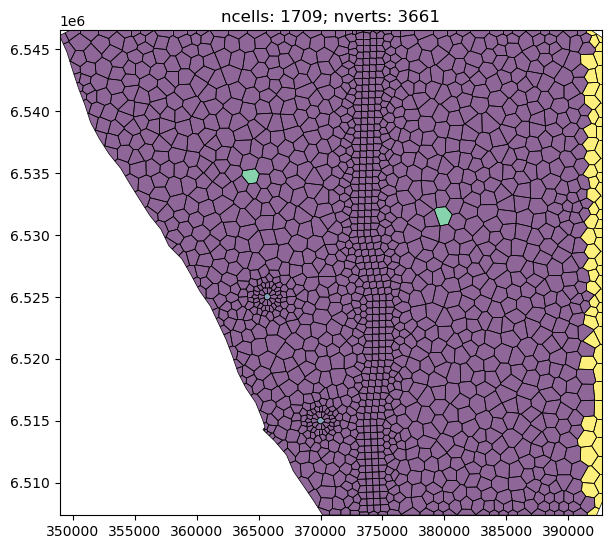

In [47]:
#------------------------CHD----------------------------
# identify cells on east_chd line
line = east_chd.geometry[0]
east_chd_cells = gi.intersect(line)["cellids"]
east_chd_cells = np.array(list(east_chd_cells))
ibd[east_chd_cells] = 3

fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(1, 1, 1, aspect="equal")
pmv = flopy.plot.PlotMapView(modelgrid=vgrid)
pmv.plot_array(ibd, alpha = 0.6)
P.vor.plot(ax=ax, edgecolor='black', lw = 0.5)

In [48]:
P.chfunc = lambda x,z: - (z * 0.02)-20 # Project specific rule for head boundary
from modelling_routines import lay_to_z
M.chd_rec = []
for icpl in east_chd_cells:
    x,y = M.xcyc[icpl][0], M.xcyc[icpl][1]
    for lay in range(M.nlay):
        z = lay_to_z(M.botm, M.top, lay, icpl=icpl)
        zb = M.botm[lay,icpl]
        if zb < P.chfunc(x,z):                           
            cell_disv = icpl + lay*(M.ncpl)
            cell_disu = M.cellid_disu.flatten()[cell_disv]
            if cell_disu != -1:
                M.chd_rec.append([cell_disu, P.chfunc(x,z)])                           
M.create_flow_package_arrays(P) 
    
#dir(M)

   Adding flow packages to  Example  ...
   Time taken =  1.298836


### 8. Write and run flow model

In [49]:
P.mfexe_name = '../exe/mf6.exe'
P.xt3d = True
results = M.write_run_model(P, period = 'Steady', ic_array = P.strt) 
M.gwf, M.head_ss, M.obs_ss, M.runtime_ss = results[0], results[1], results[2], results[-1]

   Writing simulation and gwf for  Example  ...
Period =  Steady 
   Model success =  True
   run_time =  26.025059


### 9. Visualise results

Plotting routines loaded!


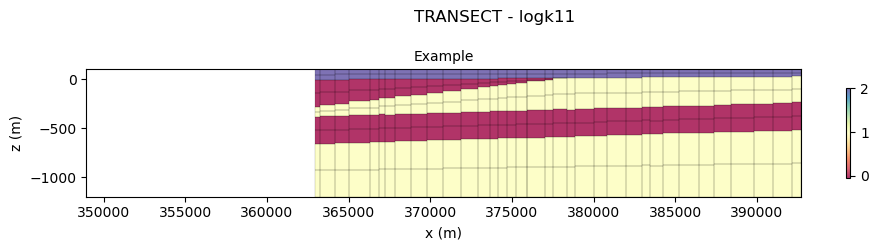

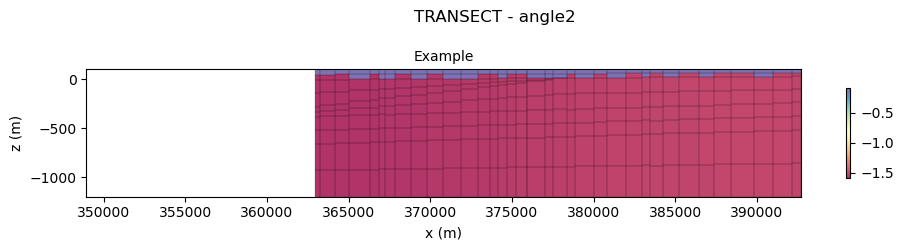

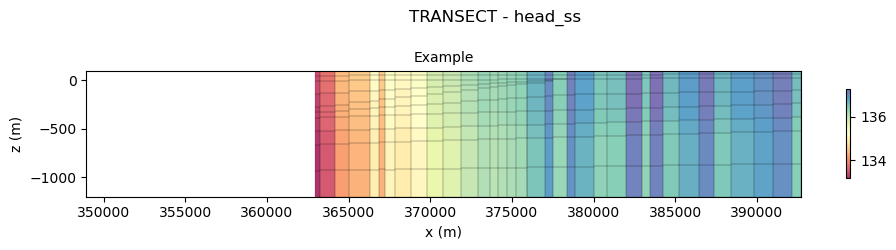

In [50]:
from plotting_routines import multiplot_prop_transect
P.idpumpbores = ['P1', 'P2']
#plot_flow_features(P, [M])
Y = 6520000
multiplot_prop_transect(P, models = [M], array = 'logk11', X0 = P.x0, Y0 = Y, X1 = P.x1, Y1 = Y)
multiplot_prop_transect(P, models = [M], array = 'angle2', X0 = P.x0, Y0 = Y, X1 = P.x1, Y1 = Y,)#vmin = -6, vmax = 0)
multiplot_prop_transect(P, models = [M], array = 'head_ss', X0 = P.x0, Y0 = Y, X1 = P.x1, Y1 = Y)#vmin = vmin, vmax = vmax)

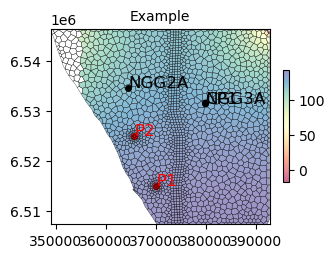

In [51]:
# It would be nice to get a "plot watertable for unstructured grids" - TBD
from plotting_routines import plot_bylayer
plot_bylayer(P, models = [M], layer = 5)#, vmin = -20, vmax = 5) 

In [52]:
#Export as VTK
vtk_workspace = '../vtk_files'
if not os.path.isdir(vtk_workspace):
    os.makedirs(vtk_workspace, exist_ok=True)
    
f = os.path.join(vtk_workspace, "example", M.modelname)
M.gwf.export(f, fmt="vtk")